In [1]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

def load_dataset(filepath):
    data = pd.read_csv(filepath)
    # Make interventions binary (this is a result of the environment's output)
    data['Was Intervention'] = data['Was Intervention'].apply(lambda x: False if x < 0 else True)
    # Once the lander is at a certain vertical position, the episode should be over, so we don't want to consider those data points
    data = data[(data['Pos Vertical'] >= 0.01) | (data['Pos Vertical'] <= -0.01)]
    return data

sensor1p_data = load_dataset('plots/data_sac_lunar_hitl_1p_sensor01.csv')
human_data = load_dataset('plots/data_human_sac_lunar_hitl_1p_sensor01.csv')
optimal_data = load_dataset('plots/data_sac_lunar_optimal.csv')
random_data = load_dataset('plots/data_sac_lunar_random.csv')

#### We have the log of state representations of evaluating a HITL agent (trained on Sensor "human" with a 1 intervention penalty) with the same Sensor pilot as the human during evaluation.
### Hypothesis
We would expect interventions to be distributed more strongly around states which are more likely to indicate imminent failure.
* Such as when the human is too far left or right, 
* moving too fast, 
* or the angle is too steep

### Results
* The distributions of the individual components of the state vector compared against when the state corresponded to an intervention and when it did not are similar in most cases.
* The two exceptions are the agent intervenes more when the position of the lander is near the bottom of the area. Also, it intervenes more when the vertical speed is high.
* One likely reason for this behavior is that the HITL autonomous agent might be intervening and correcting long before the human gets to a state where it might not be able to recover.
* Another reason is that one variable is not enough to decide when an intervention occurs, even with having a lot of data.

In [2]:
def violin_plot(dataset):
    violin_data = pd.melt(dataset, id_vars = ['Was Intervention', 'Episode Number'], var_name = 'State', value_name = 'Value')
    violin_data = violin_data[~violin_data['State'].isin(['Leg 1 Contact', 'Leg 2 Contact', 'Main Engine Action', 'Left-Right Action'])]

    # for these variables, split them up by less than 0 and greater than 0
    for state in ['Pos Horizontal', 'Speed Horizontal',  'Angle', 'Angular Speed']:
        temp = violin_data[(violin_data['State'] == state) & (violin_data['Value'] <= 0)]
        violin_data.loc[temp.index, 'State'] = state + ' <= 0'
        temp = violin_data[(violin_data['State'] == state) & (violin_data['Value'] > 0)]
        violin_data.loc[temp.index, 'State'] = state + ' > 0'

    sns.set(rc={'figure.figsize':(30, 13)}, font_scale = 1.25)
    plot = sns.violinplot(data=violin_data, x="State", y="Value", hue="Was Intervention", split=True, inner="quart", linewidth=1)
    plot.set(ylim=(-3, 3))
    return plot

<AxesSubplot:xlabel='State', ylabel='Value'>

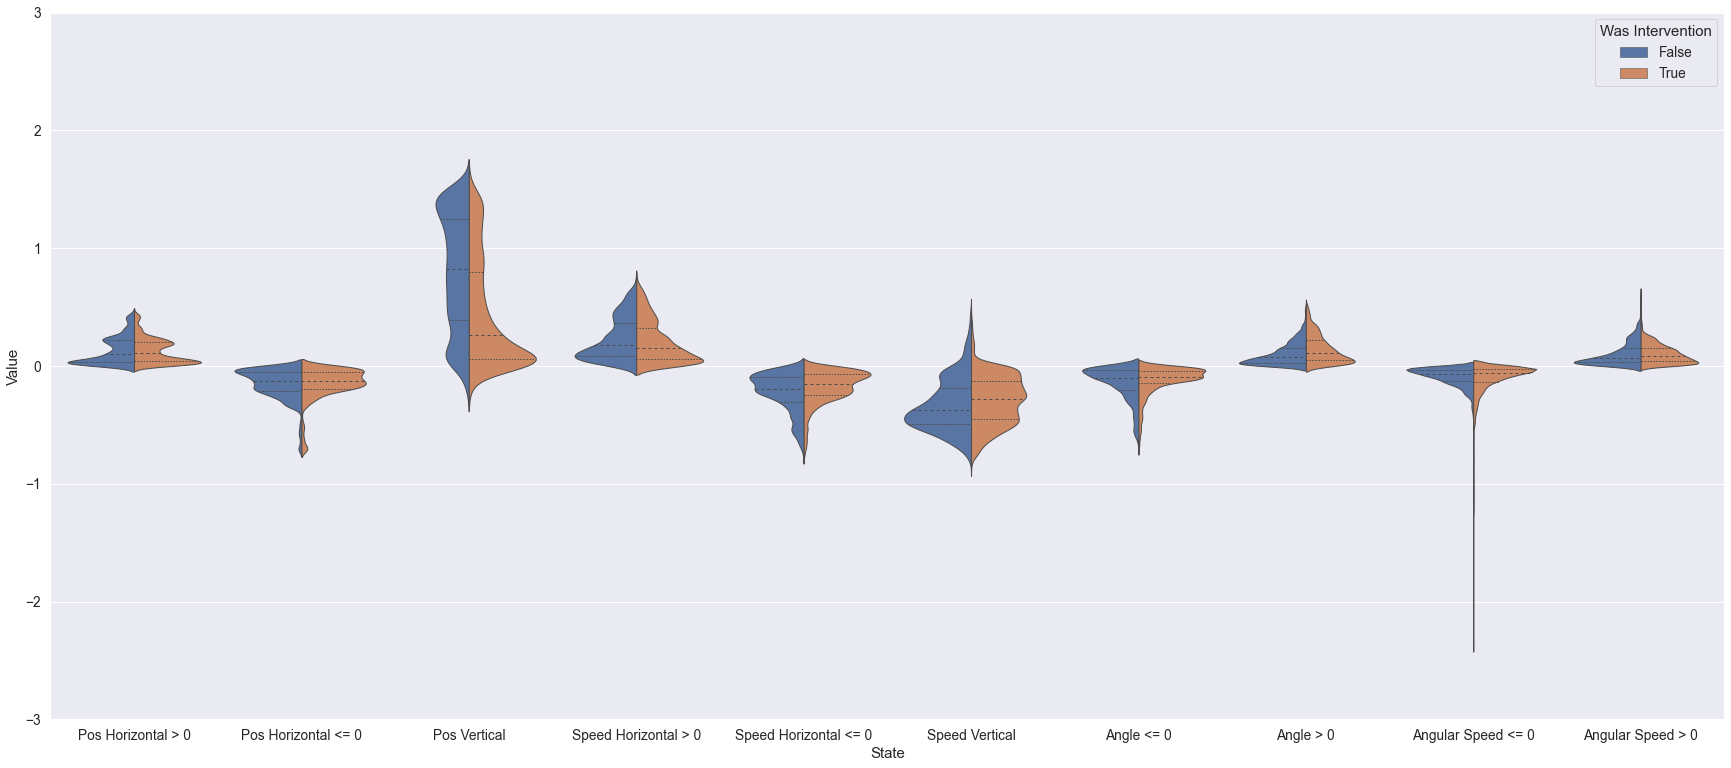

In [3]:
violin_plot(sensor1p_data)

### Same experiment, but logging data from a human playing Lunar Lander with the agent

<AxesSubplot:xlabel='State', ylabel='Value'>

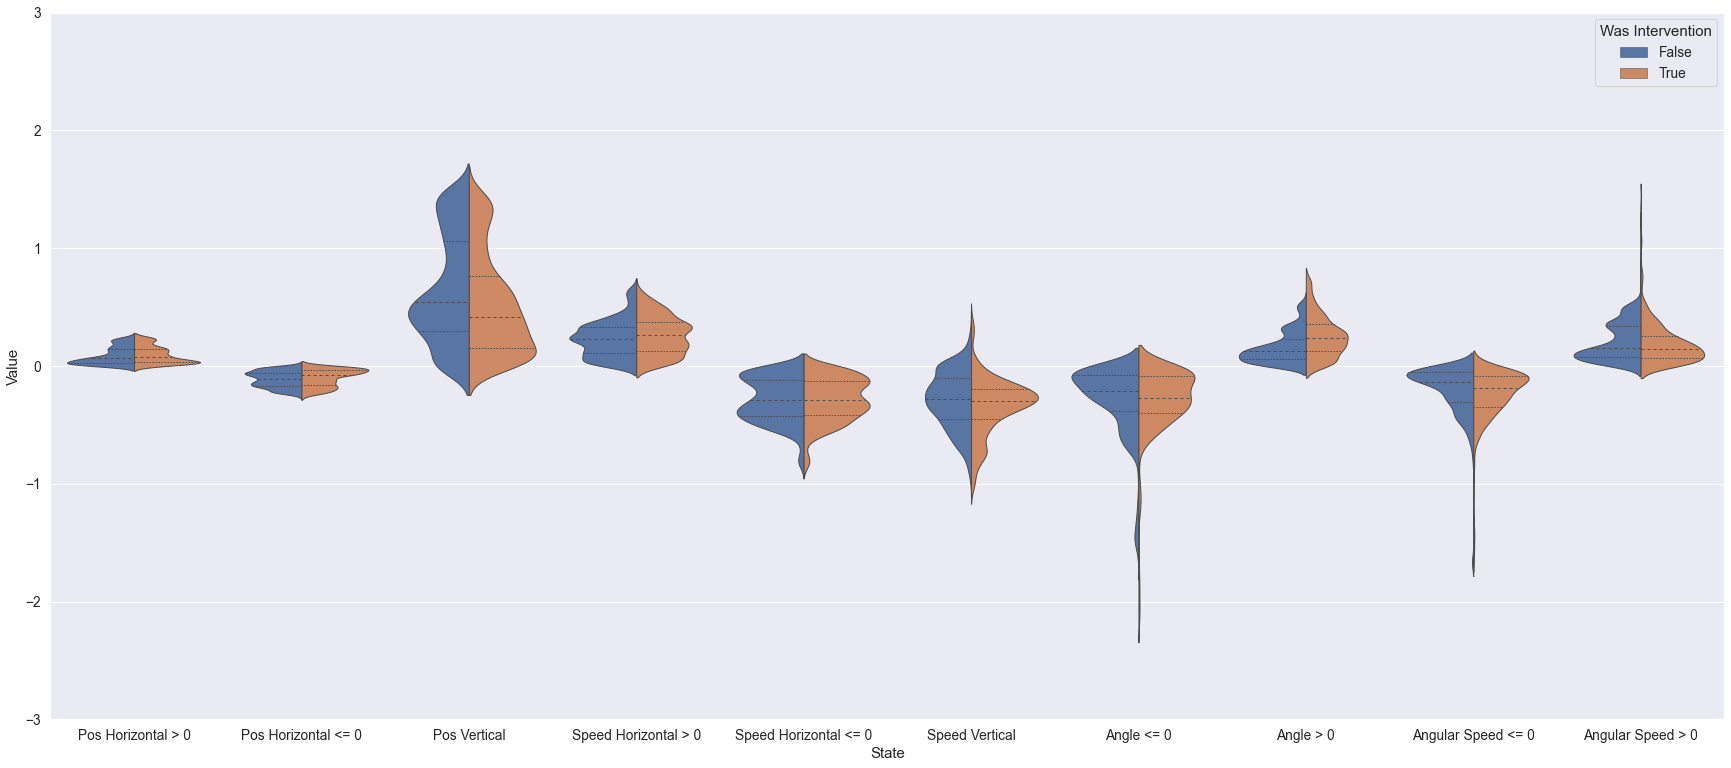

In [4]:
violin_plot(human_data)

### Data logged from the optimal lunar lander policy playing with the assistive agent.

<AxesSubplot:xlabel='State', ylabel='Value'>

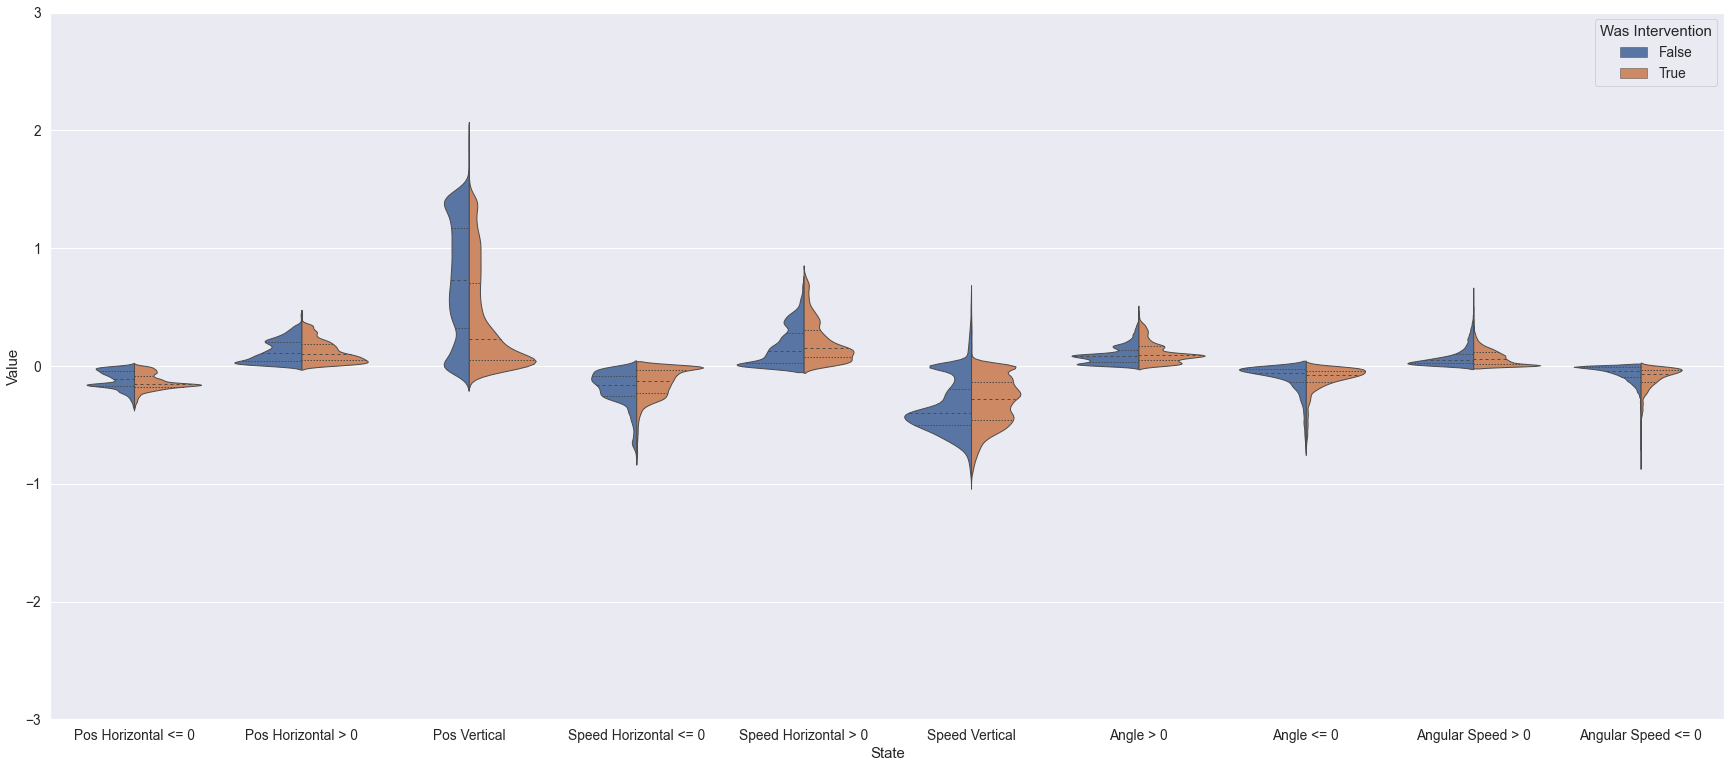

In [5]:
violin_plot(optimal_data)

### Data logged from a "human" that takes a random action everytime

<AxesSubplot:xlabel='State', ylabel='Value'>

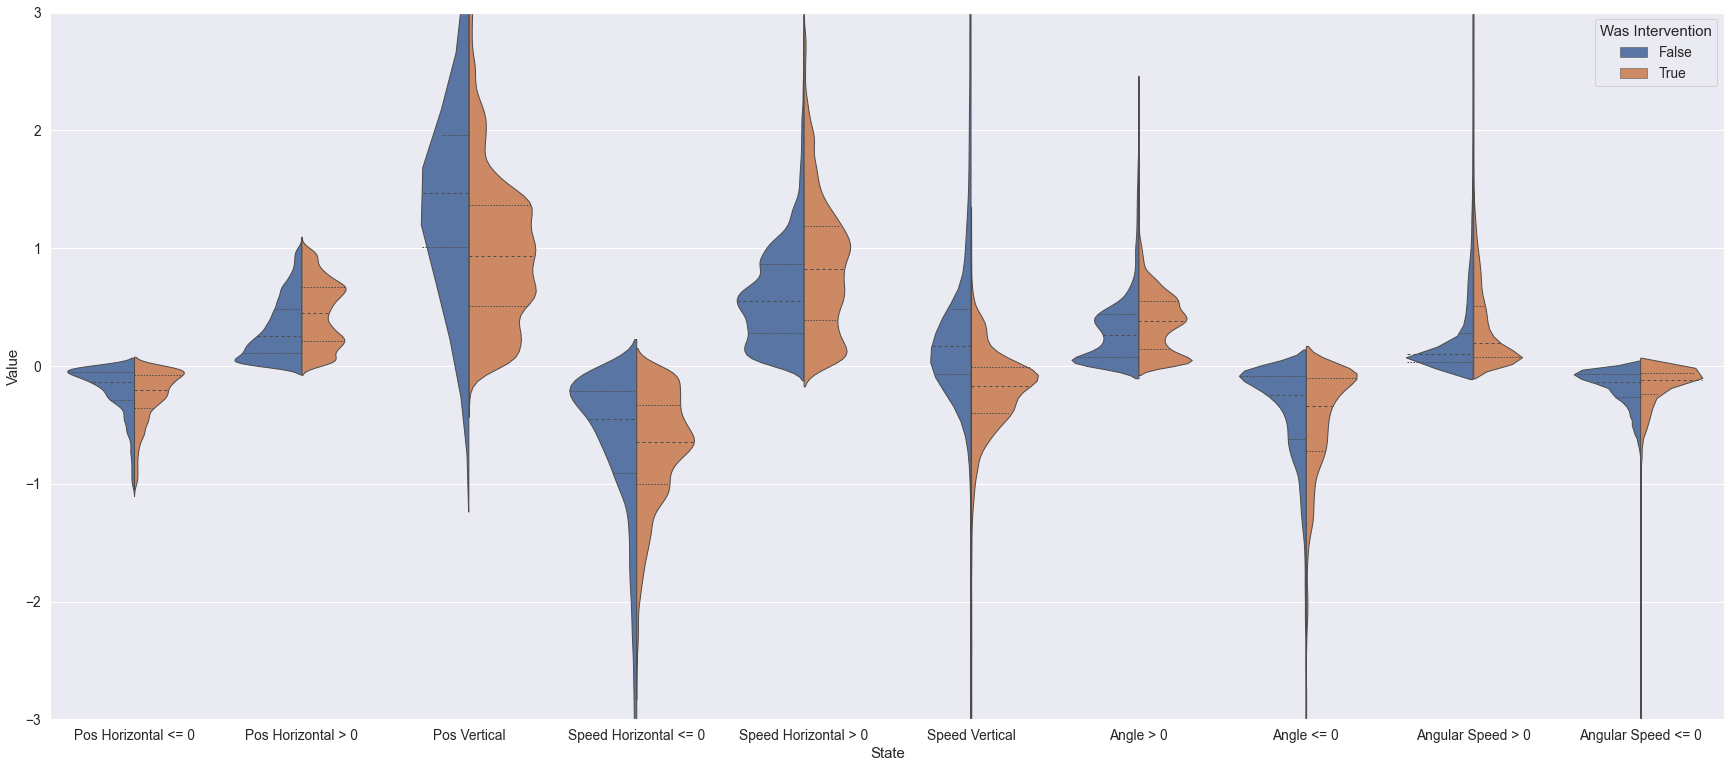

In [6]:
violin_plot(random_data)